## Aesthetic Quality Decision Tree

### Goal
This script is meant for training a BIQA decsion tree on the AVA dataset. AVA contains images and their MOS-scores based on aesthetic image quality. This dataset contains approximately 250,000 images. If needed, you can make use of the web scraper included in this Github repository in order to compile your own dataset.  

### Script
By calling get_features( ) 23 features will be extracted from an image. 


### Additional Remarks
* Please note that I did not include the AVA dataset in this Git repository. You can find the original dataset online.
* Most of the code I wrote myself. However, when external code is used, the source is referenced. 

In [1]:
import numpy as np
import pandas as pd 

from skimage import io, color, exposure, filters, measure
from skimage.transform import resize

from scipy import stats
import scipy.ndimage.filters

from sklearn import cluster
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import warnings
warnings.filterwarnings('ignore')

In [26]:
def get_features(full_img, rescale_factor, animation, theme, name, theme_str):
    
    # Image preprocessing: rescaling and clustering 
    rescaled_img, rescaled_img_gray, mode, full_size, full_ratio = preprocess(full_img, rescale_factor)
    rescaled_img_luv, kmeans_cluster, rescaled_img_range = segmentation(rescaled_img, rescaled_img_gray, mode, True)
    
    # Calculate features for rescaled image and clusters 
    exposure, contrast = feature_exposure(rescaled_img_gray) 
    rescaled_img_hsv, saturation = feature_saturation(rescaled_img, mode)
    var_0, max_0, len_0, var_1, max_1, len_1, var_2, max_2, len_2, number_areas = feature_segments(rescaled_img, kmeans_cluster, rescaled_img_range)
    
    # Calculate cropped image by salience 
    center_y, center_x, salience_img, salience_img_th = calculate_salience(rescaled_img_gray, rescaled_img_range, rescaled_img_hsv, rescale_factor, mode) 
    cropped_img, cropped_img_gray = salience_crop(center_x, center_y, full_img, rescale_factor, mode)
    
    # Calculate features for cropped image (more detail)
    cropped_img_luv, cropped_kmeans_cluster, cropped_img_range = segmentation(cropped_img, cropped_img_gray, mode, False)
    var_crop_0, var_crop_1, noise_crop = feature_crop(cropped_img, cropped_kmeans_cluster, cropped_img_range)
    sim, sim_score = similarity_dataset(rescaled_img_gray, theme_str, name)
    
    # load images for animation 
    if animation == True:
        plt.imshow(cropped_img)
    
    return([exposure, contrast, saturation, var_0, max_0, len_0, var_1, max_1, len_1, var_2, max_2, len_2, number_areas, var_crop_0, var_crop_1, noise_crop, theme, center_x, center_y, full_size, full_ratio, sim, sim_score])


In [23]:
print(full_img.shape)
full_img.shape[0] / full_img.shape[1]

(800, 534, 3)


1.4981273408239701

In [24]:
def preprocess(full_img, rescale_factor):
    rescaled_img = resize(full_img, (rescale_factor, rescale_factor), anti_aliasing = True)
    if rescaled_img.shape != (rescale_factor, rescale_factor, 3):
        mode = 'grayscale'
        rescaled_img_grayscale = rescaled_img 
    elif np.array_equal(rescaled_img[:, :, 0], rescaled_img[:, :, 1]) and np.array_equal(rescaled_img[:, :, 0], rescaled_img[:, :, 2]):
        mode = 'grayscale'
        rescaled_img_gray = color.rgb2gray(rescaled_img)
    else:
        mode = 'color'
        rescaled_img_gray = color.rgb2gray(rescaled_img)
    full_size = full_img.shape[0] * full_img.shape[1]
    full_ratio = full_img.shape[0] / full_img.shape[1]
    return(rescaled_img, rescaled_img_gray, mode, full_size, full_ratio)

def segmentation(img, img_gray, mode, calculate_number_clusters):     
    img_range = (img_gray - np.amin(img_gray)) * 255.0 / (np.amax(img_gray) - np.amin(img_gray))
 
    if mode == 'color':
        img_luv = color.rgb2luv(img)
    else:
        img_luv = np.stack((img_range, img_range, img_range), axis = 2)   

    img_med = scipy.ndimage.median_filter(img_luv, size = 2)
    
    x, y = img.shape[:2]
    img_reshape = img_med.reshape(x*y, 3)

    if calculate_number_clusters == True:              
        distortions = []
        for i in range(1, 4):
            kmeans = cluster.MiniBatchKMeans(max_iter = 2, batch_size = 2000, n_clusters = i)
            kmeans.fit(img_reshape)
            distortions.append(kmeans.inertia_)

        coef = []
        change_coef = []

        for i in range(1, 3):
            coef.append((distortions[i - 1] / distortions[i]))

        for i in range(1, 2):
            change_coef.append(coef[i] / coef[i - 1])

        count_k = 2
        for number in change_coef[1:]:
            if number < 0.8:
                count_k += 1
            else:
                break
    else:
        count_k = 2 

    kmeans = cluster.MiniBatchKMeans(max_iter = 10, batch_size = 2000, n_clusters = count_k)
    kmeans.fit(img_reshape)
    centers = kmeans.cluster_centers_
    labels = (kmeans.labels_)
    clustered = centers[labels].reshape(x, y, 3)
    clustered_int = color.rgb2gray(clustered.astype(int))
    
    return(img_luv, clustered_int, img_range)
    
def calculate_salience(img_gray, img_range, img_hsv, rescale_factor, mode):
#     https://jacobgil.github.io/computervision/saliency-from-backproj
    if mode == 'grayscale':
        black_image = np.zeros((rescale_factor, rescale_factor, 3))
        return(0.5, 0.5, black_image, black_image)

    ravel_sat = np.ravel(img_hsv[:, :, 1])
    ravel_hue = np.ravel(img_hsv[:, :, 0])
    
    full_hist, a, b = np.histogram2d(ravel_sat, ravel_hue, bins = ([0, 0.5, 1]))

    sorted_values = sorted(full_hist.ravel())

    new_image = []
    for i, pixel in enumerate(ravel_sat): 
        if pixel < 0.5:
            if ravel_hue[i] < 0.5: 
                new_pixel = 240 - sorted_values.index(full_hist[0][0]) * 80
            else:
                new_pixel = 240 - sorted_values.index(full_hist[0][1]) * 80
        else:
            if ravel_hue[i] < 0.5: 
                new_pixel = 240 - sorted_values.index(full_hist[1][0]) * 80
            else:
                new_pixel = 240 - sorted_values.index(full_hist[1][1]) * 80
        new_image.append(new_pixel)

    salience_image = np.array(new_image).reshape((rescale_factor, rescale_factor))
    salience_image = scipy.ndimage.gaussian_filter(salience_image, sigma = 8)
    salience_image = exposure.equalize_hist(salience_image)
    
    threshold = filters.threshold_otsu(salience_image)
#     plt.imshow(salience_image, cmap = 'gray')
    salience_image_th = (salience_image > threshold).astype(int)
    
    properties = measure.regionprops(salience_image_th, img_gray)
    weighted_center_of_mass = properties[0].centroid
    
#     fig, ax = plt.subplots()
#     ax.imshow(salience_image_th, cmap=plt.cm.gray)
            
#     ax.plot(weighted_center_of_mass[1], weighted_center_of_mass[0], 'ro')

#     ax.axis('image')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()
    
    return(weighted_center_of_mass[0]/rescale_factor, weighted_center_of_mass[1]/rescale_factor, salience_image, salience_image_th)

def salience_crop(center_x, center_y, full_img, rescale_factor, mode):
    height, width = full_img.shape[:2]
    x = int(center_x * width)
    y = int(center_y * height)
    original_x, original_y = x, y
    
    half_crop = 0.5 * rescale_factor
    
    if x < half_crop:
        x = half_crop 
    if y < half_crop:
        y = half_crop 
        
    if (width - x) < half_crop:
        x = width - half_crop 
    if (height - y) < half_crop:
        y = height - half_crop
    
#     fig, ax = plt.subplots()
#     ax.imshow(full_img, cmap=plt.cm.gray)
            
#     ax.plot(original_x, original_y, 'ro')
    
    x_min = int(x - half_crop)
    x_max = int(x + half_crop)
    y_min = int(y - half_crop)
    y_max = int(y + half_crop)       
    
#     bounding_box = patches.Rectangle((x_min, y_min), rescale_factor, rescale_factor, linewidth = 2, edgecolor = 'r', facecolor = 'none')
#     ax.add_patch(bounding_box)
#     ax.axis('image')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()
    
#     plt.show()

    img_crop = full_img[y_min:y_max, x_min:x_max]
    if mode == 'grayscale':
        img_crop_gray = img_crop
    else:
        img_crop_gray = color.rgb2gray(img_crop)
    
#     plt.imshow(img_crop)
    
    return(img_crop, img_crop_gray)
    

In [25]:
def feature_exposure(img):
    return((img.ravel()).var(), img.std())

def feature_saturation(img, mode):
    img_hsv = np.zeros((img.shape[0], img.shape[1], 3)) 
    if mode == 'color':
        img_hsv = color.rgb2hsv(img)
    saturation = img_hsv[:, :, 1]
    mean_saturation = np.array(saturation).mean() 
    return(img_hsv, mean_saturation)
    
def feature_segments(img, kmeans_cluster, img_range):
    seg_ravel = kmeans_cluster.ravel()
    
    kernel = np.ones((3, 3))
    kernel[1,1] = -8
    laplacian = scipy.ndimage.filters.convolve(img_range, kernel)
    ravel_laplacian = laplacian.ravel()
    
    ravel_img = img.ravel()

    areas = []
    for item in np.unique(seg_ravel):
        list_laplacian = []
        list_img = []
        for i, pixel in enumerate(seg_ravel):
            if pixel == item:
                list_laplacian.append(ravel_laplacian[i])
                list_img.append(ravel_img[i])
        array_img = np.array(list_img)
        array_laplacian = np.array(list_laplacian)
        areas.append([array_laplacian.var(), array_laplacian.max(), len(array_img)/len(seg_ravel)])
        
    number_clusters = len(areas) 

    for i in range(number_clusters, 3):
        areas.append([0, 0, 0])    

    def key(item):
        return(item[2])

    sorted_areas = sorted(areas, key = key)

    return(sorted_areas[0][0], sorted_areas[0][1], sorted_areas[0][2],
            sorted_areas[1][0], sorted_areas[1][1], sorted_areas[1][2],
            sorted_areas[2][0], sorted_areas[2][1], sorted_areas[2][2],
            number_clusters)

def feature_crop(img, kmeans_cluster, img_range):
    seg_ravel = kmeans_cluster.ravel()
    
    kernel = np.ones((3, 3))
    kernel[1,1] = -8
    laplacian = scipy.ndimage.filters.convolve(img_range, kernel)
    ravel_laplacian = laplacian.ravel()

    areas = []
    for item in np.unique(seg_ravel):
        list_laplacian = []
        for i, pixel in enumerate(seg_ravel):
            if pixel == item:
                list_laplacian.append(ravel_laplacian[i])
        array_laplacian = np.array(list_laplacian)
        areas.append(array_laplacian.var())   
    sorted_areas = sorted(areas)
    
#     kmeans_cluster_med = scipy.ndimage.median_filter(kmeans_cluster, size = 4)
#     similarity = calculate_similarity(kmeans_cluster, kmeans_cluster_med)
    full_laplacian = sorted(ravel_laplacian)
    noise_correction = int(len(full_laplacian) * 0.98)
    corrected_laplacian = full_laplacian[:noise_correction]
    noise = np.array(corrected_laplacian).max() / np.array(full_laplacian).max()

    return(sorted_areas[0], sorted_areas[1], noise)

def calculate_similarity(img1, img2):
    similarity = np.sum((img1.astype(float) - img2.astype(float)) ** 2)
    similarity = similarity / float(img1.shape[0] * img1.shape[1])
    return(similarity) 

In [6]:
data = pd.read_csv('data/koniq10k_scores_and_distributions.csv')
data = data[46:47]

for index, row in data.iterrows():
    if index % 50 == 0:
        print(index)
        print(datetime.now())
    name = row['image_name']
    print(name)
    score = row['MOS']
    
    full_img = io.imread('data/1024x768/' + name)

    features = get_features(full_img, 224, animation = True)
    print(features)

10113730664.jpg


TypeError: get_features() missing 3 required positional arguments: 'theme', 'name', and 'theme_str'

In [30]:
data = pd.read_csv('data/dpchallengedata.csv')
# data = data[:10]
X = []
y = []
errors = []
themes = {'concert': 0, 'sports': 1, 'formal': 2}

for index, row in data.iterrows():
    if index % 50 == 0:
        print(index)
        print(datetime.now())
    name = str(row['id'])
    score = row['score']
    theme = themes.get(row['theme'])
    theme_string = str(row['theme'])
    
    try:
        full_img = io.imread('data/images_scraped/' + name + '.jpg')
        features = get_features(full_img, 224, animation = False, theme = theme, name = name, theme_str = theme_string)
        y.append(score)
        X.append(features)
    except:
        print('Error ' + name)
        errors.append(name)
        

0
2020-06-29 21:56:55.576230
Error 121301
Error 465849
Error 705217
Error 788763
Error 879162
50
2020-06-29 21:57:52.786875
Error 1190475
Error 1200540
Error 1243036
Error 218557
Error 405782
Error 534491
Error 621535
100
2020-06-29 21:59:25.929138
Error 45155
Error 326782
Error 587977
Error 1207687
Error 80604
150
2020-06-29 22:00:54.891624
Error 571102
Error 666504
Error 673504
Error 98866
Error 532019
Error 748903
200
2020-06-29 22:02:04.785690
Error 1069450
Error 1138151
Error 338317
Error 23425
Error 30684
250
2020-06-29 22:03:18.053622
Error 47597
Error 59135
Error 64344
Error 64882
Error 65723
Error 111875
300
2020-06-29 22:05:06.589386
Error 131168
Error 152619
Error 158488
Error 214974
Error 218521
350
2020-06-29 22:06:01.604535
Error 275067
Error 297028
Error 66533
Error 134023
400
2020-06-29 22:07:17.211974
Error 286971
Error 328803
Error 492091
450
2020-06-29 22:08:23.240549
Error 634686
Error 722430
Error 730511
Error 734413
Error 829975
500
2020-06-29 22:09:16.712801
Erro

In [37]:
# import json
# with open('y_aesthetics.json', 'w') as outfile:
#     json.dump(y, outfile)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [184]:
clf = tree.DecisionTreeRegressor(max_depth = 6, min_samples_split = 150, min_samples_leaf = 1)
clf = clf.fit(X_train, y_train)

PLCC: 0.1872966644715756
SROCC: 0.18088940955424107
MSE: 0.476289948761464


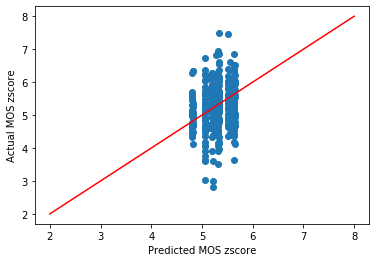

In [185]:
predicted = clf.predict(X_test)
actual = y_test
plcc, p_plcc = stats.pearsonr(predicted, actual)
srocc, p_srocc = stats.spearmanr(predicted, actual)
mse = mean_squared_error(predicted, actual)
print("PLCC: " + str(plcc))
print("SROCC: " + str(srocc))
print("MSE: " + str(mse))
plt.scatter(predicted, actual)
plt.xlabel("Predicted MOS zscore")
plt.ylabel ("Actual MOS zscore")
plt.plot([2, 8], [2, 8], color = "red")

In [186]:
# import pickle
# pickle.dump(clf, open('quality_model_29-6.sav', 'wb'))
# print(23/16 * 6)
print(clf.feature_importances_)
# print(len(X[0]))

[0.         0.         0.07411404 0.         0.         0.
 0.08005165 0.07001826 0.         0.04600042 0.04592236 0.
 0.         0.06066669 0.16572757 0.03284778 0.         0.03836787
 0.         0.28256767 0.06829817 0.03541752 0.        ]


median plcc:  0.18800623703827057
median srocc:  0.19226906322439843
1 0.0
2 0.0
3 0.04324318504079737
4 0.0
5 0.0
6 0.0
7 0.06059504510634756
8 0.0476211368138459
9 0.0
10 0.04204172728521724
11 0.030094884765890666
12 0.0
13 0.0
14 0.03576488526531223
15 0.2524136838537264
16 0.04509265894774038
17 0.0
18 0.0
19 0.022346192693910562
20 0.3212837807125504
21 0.0
22 0.0
23 0.021552677975460878


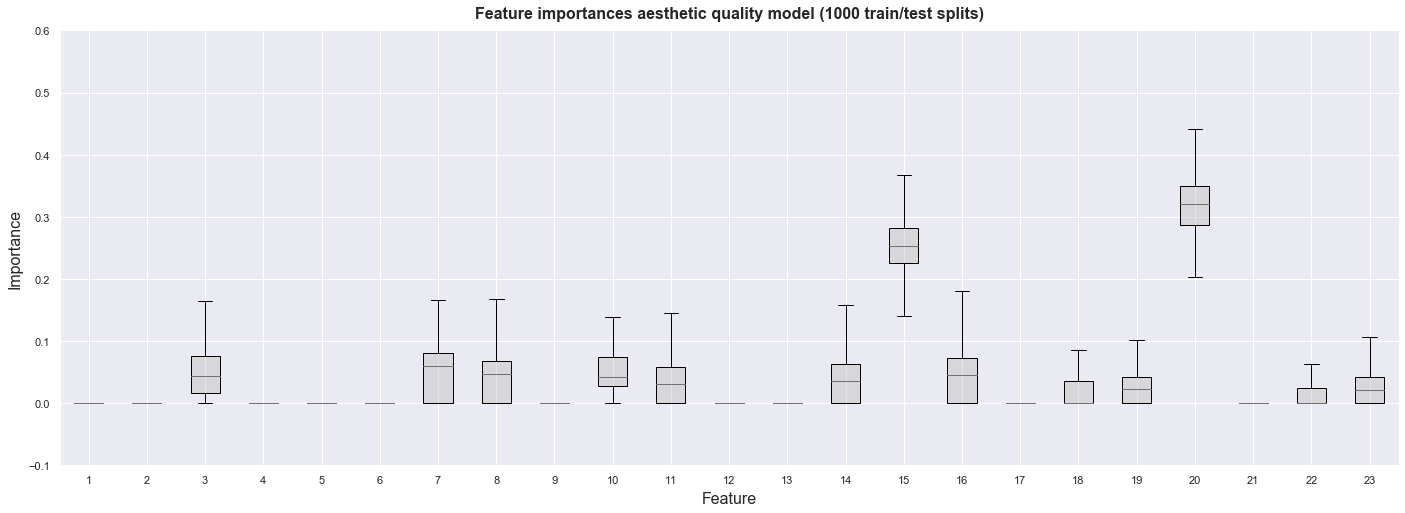

In [193]:
import seaborn as sns
sns.set()
# import statistics
# all_plcc = []
# all_srocc = []
# importances = [[] for x in range(23)]

# for i in range(1000): 

#     X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size = 0.2, random_state = i)

#     regressor = tree.DecisionTreeRegressor(max_depth = 6, min_samples_split = 150, min_samples_leaf = 1)
#     regressor = regressor.fit(X_train_new, y_train_new)
    
#     feature_importances = regressor.feature_importances_
#     for i in range(len(feature_importances)):
#         importance = feature_importances[i]
#         importances[i].append(importance)

#     predicted = regressor.predict(X_test_new)

#     actual = y_test_new
#     plcc, p_plcc = stats.pearsonr(predicted, actual)
#     srocc, p_srocc = stats.spearmanr(predicted, actual)
#     all_plcc.append(plcc)
#     all_srocc.append(srocc)

print('median plcc: ', statistics.median(all_plcc))
print('median srocc: ', statistics.median(all_srocc))
# regressor = pickle.load(open('used_in_app_model.sav', 'rb'))
# print(regressor.get_params())

fig, ax = plt.subplots(figsize = (24, 8))
plt.ylim(-0.1, 0.6)
plt.title('Feature importances aesthetic quality model (1000 train/test splits)', pad = 12, fontweight = 'bold', linespacing = 1.8, fontsize = 16)
plt.xlabel('Feature', labelpad = 6, fontsize = 16)
plt.ylabel('Importance', labelpad = 6, fontsize = 16)
# plt.tick_params(axis = 'both', labelsize = 12)
median_style = {'color': '#717171'}
boxplot = plt.boxplot(importances, medianprops = median_style, patch_artist = True, showfliers = False)
for box in boxplot['boxes']:
    box.set_facecolor('#b5b5b560')
    
for i, feature in enumerate(importances):
    print(i + 1, statistics.median(feature))
    
plt.savefig('Feature importances aesthetics 29-6.png', dpi=300)    

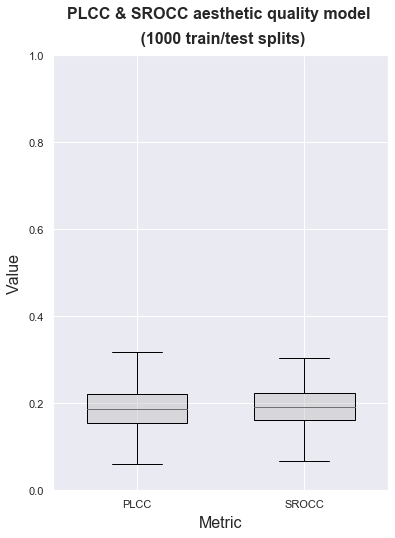

In [194]:
fig, ax = plt.subplots(figsize = (6, 8))
plt.ylim(-0.0, 1.0)
plt.title('PLCC & SROCC aesthetic quality model \n (1000 train/test splits)', pad = 12, fontweight = 'bold', linespacing = 1.8, fontsize = 16)
plt.xlabel('Metric', labelpad = 6, fontsize = 16)
plt.ylabel('Value', labelpad = 6, fontsize = 16)
median_style = {'color': '#717171'}
boxplot = plt.boxplot([all_plcc, all_srocc], medianprops = median_style, patch_artist = True, showfliers = False, labels = ['PLCC', 'SROCC'], widths = (0.6, 0.6))
for box in boxplot['boxes']:
    box.set_facecolor('#b5b5b560')
    
plt.savefig('PLCC-SROCC aesthetics 29-6.png', dpi=300)  

0
2020-05-16 19:07:32.083964
50
2020-05-16 19:07:34.927357
100
2020-05-16 19:07:38.890239
150
2020-05-16 19:07:38.935469
200
2020-05-16 19:07:38.942985
250
2020-05-16 19:07:40.611264
300
2020-05-16 19:07:43.099536
350
2020-05-16 19:07:45.587026
400
2020-05-16 19:07:46.847652
450
2020-05-16 19:07:46.855956
500
2020-05-16 19:07:46.863098
550
2020-05-16 19:07:46.870391
600
2020-05-16 19:07:46.877789
650
2020-05-16 19:07:46.885190
700
2020-05-16 19:07:46.892879
750
2020-05-16 19:07:46.900013
800
2020-05-16 19:07:46.907820
850
2020-05-16 19:07:46.915106
900
2020-05-16 19:07:46.923706
950
2020-05-16 19:07:46.931171
1000
2020-05-16 19:07:46.939083
1050
2020-05-16 19:07:46.947667
1100
2020-05-16 19:07:46.954992
1150
2020-05-16 19:07:46.963092
1200
2020-05-16 19:07:46.970881
1250
2020-05-16 19:07:46.978691
1300
2020-05-16 19:07:46.986156
1350
2020-05-16 19:07:46.993873
1400
2020-05-16 19:07:47.001467
1450
2020-05-16 19:07:47.008870
1500
2020-05-16 19:07:47.016903
1550
2020-05-16 19:07:47.024321

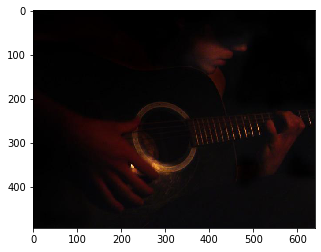

In [51]:
from skimage import data
from skimage.feature import Cascade
import glob

import matplotlib.pyplot as plt

# img = data.astronaut()
img = io.imread('data/baseball_presentation/9329063181_a85ef74c89_c.jpg')
img = io.imread('data/baseball_presentation/9329090321_a76b0f9e9c_c.jpg')
# img = io.imread('data/images_scraped/25882.jpg')
img = io.imread('data/images_scraped/232868.jpg')
img = io.imread('data/images_scraped/677472.jpg')
img = io.imread('data/images_scraped/60343.jpg')
img = color.rgb2gray(resize(img, (224, 224), anti_aliasing = True)) 
# img = img.flatten()
# test1 = np.histogram(img)

images = glob.glob('data/baseball_presentation/*')
ims_candidates = []

def key(item):
    return(item[0])

# for name in images:
#     im = io.imread(name)
#     cropped_im = color.rgb2gray(resize(im, (224, 224), anti_aliasing = True))
#     sim = calculate_similarity(img, cropped_im)
#     ims_candidates.append([sim, name])

data = pd.read_csv('data/dpchallengedata.csv')
# data = data[0:400]
X = []
y = []
themes = {'concert': 0, 'sports': 1, 'formal': 2}

for index, row in data.iterrows():
    if index % 50 == 0:
        print(index)
        print(datetime.now())
#     name = row['image_name']
#     score = row['MOS_zscore']
    try:
        name = str(row['id'])
        score = row['score']
        theme = themes.get(row['theme'])
        if theme == 0:
            im = io.imread('data/images_scraped/' + name + '.jpg')
            cropped_im = color.rgb2gray(resize(im, (224, 224), anti_aliasing = True))
#             cropped_im = cropped_im.flatten() 
    #         test = np.histogram(cropped_im)
            sim = calculate_similarity(img, cropped_im)
#             sim = distance.chebyshev(cropped_im, img)
            ims_candidates.append([sim, 'data/images_scraped/' + name + '.jpg', score, theme])
    except: 
        print('Error')
    
sorted_list = sorted(ims_candidates, key = key)
print(sorted_list[:15])
plt.imshow(io.imread(sorted_list[1][1]))
# plt.imshow(cropped_im)

In [36]:
# plt.imshow(cropped_im)
from scipy.spatial import distance 
img1 = io.imread('data/images_scraped/218428.jpg')
img2 = io.imread('data/images_scraped/218428.jpg')
img2 = io.imread('data/images_scraped/25882.jpg')
cropped_im1 = (color.rgb2gray(resize(img1, (40, 40), anti_aliasing = True))).flatten()
cropped_im2 = (color.rgb2gray(resize(img2, (40, 40), anti_aliasing = True))).flatten()
# print(cropped_im.flatten())
# plt.imshow(img)
distance.chebyshev(cropped_im1, cropped_im2)

0.3350218431372548

In [8]:
data = pd.read_csv('data/dpchallengedata.csv')
themes = {'concert': 0, 'sports': 1, 'formal': 2}
cropped_ims = []

for index, row in data.iterrows():
    if index % 100 == 0:
        print(index)
        print(datetime.now())
#     name = row['image_name']
#     score = row['MOS_zscore']
    name = str(row['id'])
    im = io.imread('data/images_scraped/' + name + '.jpg')
    cropped_im = color.rgb2gray(resize(im, (224, 224), anti_aliasing = True))
    cropped_ims.append(cropped_im)

0
2020-06-29 21:32:25.361313
100
2020-06-29 21:32:31.990366
200
2020-06-29 21:32:38.350609
300
2020-06-29 21:32:43.990866
400
2020-06-29 21:32:49.143277
500
2020-06-29 21:32:54.263238
600
2020-06-29 21:33:01.956660
700
2020-06-29 21:33:08.415203
800
2020-06-29 21:33:14.717545
900
2020-06-29 21:33:21.487898
1000
2020-06-29 21:33:28.563111
1100
2020-06-29 21:33:34.441215
1200
2020-06-29 21:33:43.969974
1300
2020-06-29 21:33:50.713208
1400
2020-06-29 21:33:55.604330
1500
2020-06-29 21:34:01.304817
1600
2020-06-29 21:34:10.268063
1700
2020-06-29 21:34:18.722541
1800
2020-06-29 21:34:25.259625
1900
2020-06-29 21:34:30.805041
2000
2020-06-29 21:34:35.885059


In [9]:
from copy import deepcopy
data2 = deepcopy(data)
data2['img_crop'] = cropped_ims

In [10]:
data2

,Unnamed: 0,id,link,score,theme,img_crop
0,0,23488,https://images.dpchallenge.com/images_challeng...,4.3636,concert,"[[0.967050980392157, 0.9670509803921569, 0.967..."
1,1,34867,https://images.dpchallenge.com/images_challeng...,6.1311,concert,"[[0.9802659768907562, 0.9818237580032014, 0.97..."
2,2,36609,https://images.dpchallenge.com/images_challeng...,4.8978,concert,"[[0.007901848739495811, 0.007024929971988853, ..."
3,3,40374,https://images.dpchallenge.com/images_challeng...,4.8771,concert,"[[0.5884682352941176, 0.5926955902986197, 0.58..."
4,4,59021,https://images.dpchallenge.com/images_challeng...,4.5862,concert,"[[0.9610521568627453, 0.961052156862745, 0.961..."
...,...,...,...,...,...,...
2034,2085,400688,https://images.dpchallenge.com/images_challeng...,5.5000,concert,"[[0.1779207843137254, 0.2057540588735495, 0.23..."
2035,2086,402219,https://images.dpchallenge.com/images_challeng...,6.2240,concert,"[[0.8287521200980389, 0.8311045454431772, 0.82..."
2036,2087,402865,https://images.dpchallenge.com/images_challeng...,5.2242,concert,"[[0.026467461984792745, 0.019801045418167344, ..."
2037,2088,403719,https://images.dpchallenge.com/images_challeng...,6.5498,concert,"[[0.008408627450980392, 0.008408627450980392, ..."


In [11]:
img1 = io.imread('data/images_scraped/25882.jpg')
img1 = io.imread('data/images_scraped/7311.jpg')

cropped_im1 = (color.rgb2gray(resize(img1, (224, 224), anti_aliasing = True)))

def similarity_dataset(cropped_img1, img_theme, img_name):
    sim_scores = []

    for index, row in data2.iterrows():
        name = str(row['id'])
        theme = str(row['theme'])
        score = row['score']
        if theme == img_theme and name != img_name:
            cropped_img2 = row['img_crop']
            sim = calculate_similarity(cropped_img2, cropped_img1)
            sim_scores.append([sim, score])

    def key(item):
        return(item[0])

    sorted_list = sorted(sim_scores, key = key)[:5]
    sim_values = []
    sim_scores = []
    for reference in sorted_list:
        sim_values.append(reference[0])
        sim_scores.append(reference[1])
    return(np.array(sim_values).mean(), np.array(sim_scores).mean())

similarity_dataset(cropped_im1, img_theme = 'concert', img_name = '7311')

(0.0041223406026608235, 4.7044)

In [262]:
data = pd.read_csv('data/dpchallengedata.csv')
data[data.theme == 'concert']

,Unnamed: 0,id,link,score,theme
0,0,23488,https://images.dpchallenge.com/images_challeng...,4.3636,concert
1,1,34867,https://images.dpchallenge.com/images_challeng...,6.1311,concert
2,2,36609,https://images.dpchallenge.com/images_challeng...,4.8978,concert
3,3,40374,https://images.dpchallenge.com/images_challeng...,4.8771,concert
4,4,59021,https://images.dpchallenge.com/images_challeng...,4.5862,concert
...,...,...,...,...,...
2034,2085,400688,https://images.dpchallenge.com/images_challeng...,5.5000,concert
2035,2086,402219,https://images.dpchallenge.com/images_challeng...,6.2240,concert
2036,2087,402865,https://images.dpchallenge.com/images_challeng...,5.2242,concert
2037,2088,403719,https://images.dpchallenge.com/images_challeng...,6.5498,concert
